In [1]:
from proj_utils.fake_input_generator import generator
from proj_utils.input_interpreter import format_input

In [2]:

import matplotlib.pyplot as plt

from VRP.greedy_solutions import nearest_neighbour_solution,random_solution
from VRP.modify_solution import *
from VRP.verify_solution import valid_path, calculate_path_distance, num_vehicles
from VRP.compare_solutions import num_different_edges


from proj_utils.path import print_path


import pandas as pd
import simulated_annealing.solver as SA
import taboo_search.solver as TS

from multi_agent.solver_model import MultiAgentSolverModel
from multi_agent.colaboration_types import ColaborationTypes
from solver_step import SolverStep
from multi_agent.solution_pool import solution_pool_simple
import pandas as pd

In [64]:
customer_df = pd.read_excel('data/2_detail_table_customers.xls')
deposit_df = pd.read_excel('data/4_detail_table_depots.xls')
routes = customer_df['ROUTE_ID'].unique()
chosen_route = routes[6]
dists, demand, points = format_input(chosen_route,customer_df,deposit_df)

colab = ColaborationTypes.FRIENDS

truck_volume_capacity = 30
truck_weight_capacity = 20000
truck_capacity = (truck_weight_capacity, truck_volume_capacity)

In [65]:
eval_function = lambda x: 0.3*num_vehicles(x) + calculate_path_distance(x, dists) if(valid_path(x,truck_capacity,demand)) else float('inf')

In [66]:
def init_step_generator():
    init_state = random_solution(dists, demand, truck_capacity)
    init_step = SolverStep(init_state,eval_function(init_state),200)

    return SolverStep(init_state,eval_function(init_state),200)

# Multi Agents without Q-Learning

In [7]:
neighbour_function = lambda x: combined_rand_modification(x, len(points), dists)

In [8]:
solver_step_SA = SA.generic_solver_factory(
    neighbour_function,
    eval_function,
    )

In [9]:
taboo_list_size = 10
solver_step_TS = TS.taboo_search_solver_factory(
    neighbour_function,
    eval_function,
    taboo_list_size
    )

In [10]:
step_function_list = [solver_step_SA, solver_step_TS]
agent_labels = ['simulated annealing', 'taboo search']

In [11]:
solution_pool = solution_pool_simple(num_different_edges, radious=2)
sol_model = MultiAgentSolverModel(
    init_step_generator,
     step_function_list,
     chosen_route,20000,30,
     solution_pool,
     10,
     colaboration_type = colab,
     agent_labels = agent_labels,
    )

C:\Users\andre\AppData\Roaming\Python\Python311\site-packages\mesa\time.py:82: FutureWarning: The AgentSet is experimental. It may be changed or removed in any and all future releases, including patch releases.
We would love to hear what you think about this new feature. If you have any thoughts, share them with us here: https://github.com/projectmesa/mesa/discussions/1919
  self._agents: AgentSet = AgentSet(agents, model)


In [12]:
for _ in range(50):
    sol_model.step()

population generated


In [13]:
sol_states = sol_model.datacollector.get_model_vars_dataframe()

In [317]:
sa = agent_sol_states.loc[0][:]['agentBestValue']
ts = agent_sol_states.loc[1][:]['agentBestValue']
ga = agent_sol_states.loc[2][:]['agentBestValue']

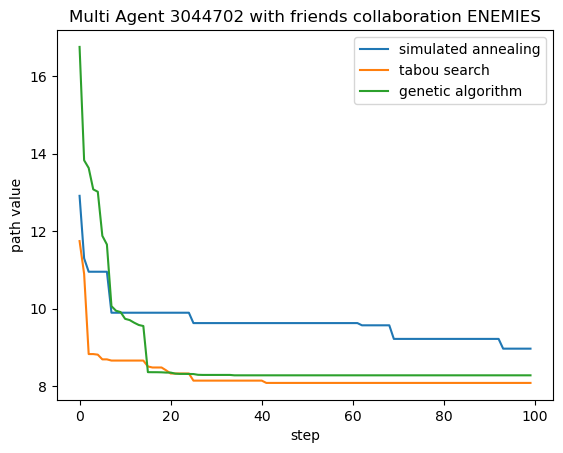

In [318]:
x = [x for x in range(len(sa))]

plt.plot(x,sa, label='simulated annealing')
plt.plot(x,ts, label='tabou search')
plt.plot(x,ga, label='genetic algorithm')
plt.legend()
plt.xlabel("step")
plt.ylabel("path value")
plt.title(f"Multi Agent {chosen_route} with friends collaboration {colab}")
plt.savefig(f"Multi Agent {chosen_route} with friends collaboration {colab}")

# Multi Agents with Q-Learning

In [67]:
from q_learning import *

function_list = [
    lambda x:intra_route_swap(x,len(dists),dists),
    lambda x:inter_route_swap(x,len(dists),dists),
    lambda x:intra_route_shift(x,len(dists),dists),
    lambda x:inter_route_shift(x,len(dists),dists),
    lambda x:two_intra_route_shift(x,len(dists),dists),
    lambda x:two_intra_route_swap(x,len(dists),dists),
    lambda x:remove_smallest_route(x,len(dists),dists),
    lambda x:remove_random_route(x,len(dists),dists),
    lambda x:split_biggest_route(x,len(dists),dists),
    lambda x:split_random_route(x,len(dists),dists)
    ]

q = q_learning_obj(0,init_q_learning_table(len(function_list)),len(function_list), 0.9, 0.1)
neighbour_function = lambda x: q_learning_iteration(x,q,function_list,eval_function)

In [68]:
solver_step_SA = SA.generic_solver_factory(
    neighbour_function,
    eval_function,
    )

In [69]:
taboo_list_size = 10
solver_step_TS = TS.taboo_search_solver_factory(
    neighbour_function,
    eval_function,
    taboo_list_size
    )

In [70]:
step_function_list = [solver_step_SA, solver_step_TS]
agent_labels = ['simulated annealing', 'taboo search']

In [71]:
solution_pool = solution_pool_simple(num_different_edges, radious=2)
sol_model = MultiAgentSolverModel(
    init_step_generator,
     step_function_list,
     chosen_route,20000,30,
     solution_pool,
     10,
     colaboration_type = ColaborationTypes.FRIENDS,
     QLearn_q = q,
     QLearn_neighbor_function_list = function_list,
     QLearn_eval_function = eval_function,
     agent_labels = agent_labels
     )

In [72]:
for _ in range(100):
    sol_model.step()

population generated


In [56]:
sol_states = sol_model.datacollector.get_model_vars_dataframe()

In [57]:
print(sol_model.datacollector.get_agent_vars_dataframe().loc[100])
agent_sol_states = sol_model.datacollector.get_agent_vars_dataframe().swaplevel(0, 1, axis=0)

                 agent label  \
AgentID                        
0        simulated annealing   
1               taboo search   
2          genetic algorithm   

                                                 agentBest  agentBestValue  
AgentID                                                                     
0        [0, 41, 89, 75, 61, 83, 21, 29, 38, 90, 76, 27...         3.57242  
1        [0, 41, 89, 75, 61, 83, 21, 29, 38, 90, 76, 27...         3.57242  
2        [0, 74, 41, 89, 3, 78, 22, 72, 32, 6, 33, 34, ...         6.25170  


In [58]:
sa = agent_sol_states.loc[0][:]['agentBestValue']
ts = agent_sol_states.loc[1][:]['agentBestValue']
ga = agent_sol_states.loc[2][:]['agentBestValue']

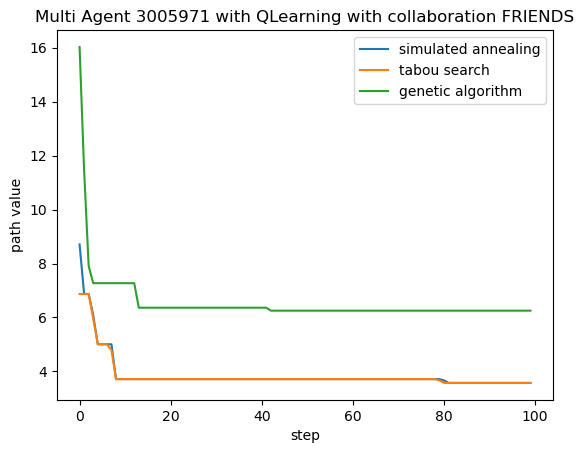

In [73]:
x = [x for x in range(len(sa))]

plt.plot(x,sa, label='simulated annealing')
plt.plot(x,ts, label='tabou search')
plt.plot(x,ga, label='genetic algorithm')
plt.legend()
plt.xlabel("step")
plt.ylabel("path value")
plt.title(f"Multi Agent {chosen_route} with QLearning with collaboration {colab}")
plt.savefig(f"Multi Agent {chosen_route} with QLearning with collaboration {colab}")